In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [4]:
path_arquivos = 'arquivos'

In [6]:
df_2010 = pd.read_csv(f'{path_arquivos}/microdados_ed_basica_2010.csv', encoding='latin2', sep=';')
df_2011 = pd.read_csv(f'{path_arquivos}/microdados_ed_basica_2011.csv', encoding='latin2', sep=';')
df_2012 = pd.read_csv(f'{path_arquivos}/microdados_ed_basica_2012.csv', encoding='latin2', sep=';')
df_2013 = pd.read_csv(f'{path_arquivos}/microdados_ed_basica_2013.csv', encoding='latin2', sep=';')
df_2014 = pd.read_csv(f'{path_arquivos}/microdados_ed_basica_2014.csv', encoding='latin2', sep=';')
df_2015 = pd.read_csv(f'{path_arquivos}/microdados_ed_basica_2015.csv', encoding='latin2', sep=';')

df_final = pd.concat([df_2010, df_2011, df_2012, df_2013, df_2014, df_2015],
                     axis=0,
                     ignore_index=True)

# filtrando os dados do RJ e apenas colegios que possuem ensino médio

df_rj = df_final[(df_final['SG_UF'] == 'RJ') & (df_final['IN_MED'] == 1)]

dados_infraestrutura = [
    'NU_ANO_CENSO',
    'CO_ENTIDADE',
    'TP_DEPENDENCIA',
    'SG_UF',
    'IN_BIBLIOTECA_SALA_LEITURA',
    'IN_LABORATORIO_CIENCIAS',
    'IN_AUDITORIO',
    'IN_INTERNET',
]

df_rj = df_rj[dados_infraestrutura]

/var/folders/03/d6yxpdv96ysdhkg86ym_8kh00000gn/T/ipykernel_88332/1224312518.py:1: DtypeWarning: Columns (20,21,25,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2010 = pd.read_csv(f'{path_arquivos}/microdados_ed_basica_2010.csv', encoding='latin2', sep=';')
/var/folders/03/d6yxpdv96ysdhkg86ym_8kh00000gn/T/ipykernel_88332/1224312518.py:2: DtypeWarning: Columns (20,21,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2011 = pd.read_csv(f'{path_arquivos}/microdados_ed_basica_2011.csv', encoding='latin2', sep=';')
/var/folders/03/d6yxpdv96ysdhkg86ym_8kh00000gn/T/ipykernel_88332/1224312518.py:3: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2012 = pd.read_csv(f'{path_arquivos}/microdados_ed_basica_2012.csv', encoding='latin2', sep=';')
/var/folders/03/d6yxpdv96ysdhkg86ym_8kh00000gn/T/ipykernel_88332/1224312518.py:4: DtypeWarning: Columns (27) have mixed types. Spe

In [8]:
# carregando, filtrando e manipulando dados sobre o Enem por escola

df_enem = pd.read_csv(f'{path_arquivos}/MICRODADOS_ENEM_ESCOLA.csv',
                     encoding='latin2',
                     sep=';')

years_to_include = [2010, 2011, 2012, 2013, 2014, 2015]
colunas_selecionadas = ['CO_ESCOLA_EDUCACENSO', 'NU_ANO', 'SG_UF_ESCOLA',
                       'TP_DEPENDENCIA_ADM_ESCOLA', 'NU_TAXA_PARTICIPACAO', 'NU_TAXA_APROVACAO', 'TP_LOCALIZACAO_ESCOLA', 
                       'NU_MEDIA_CN', 'NU_MEDIA_CH', 'NU_MEDIA_LP', 'NU_MEDIA_MT', 'NU_MEDIA_RED']

df_enem_final = df_enem[
    (df_enem['SG_UF_ESCOLA'] == 'RJ') &
    (df_enem['NU_ANO'].isin(years_to_include))
][colunas_selecionadas].copy()

df_enem_final = df_enem_final.rename(columns={
    'CO_ESCOLA_EDUCACENSO': 'CO_ENTIDADE',
    'NU_ANO': 'NU_ANO_CENSO',
    'SG_UF_ESCOLA': 'SG_UF',
    'TP_DEPENDENCIA_ADM_ESCOLA': 'TP_DEPENDENCIA'
})

/var/folders/03/d6yxpdv96ysdhkg86ym_8kh00000gn/T/ipykernel_88332/4120552926.py:3: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_enem = pd.read_csv(f'{path_arquivos}/MICRODADOS_ENEM_ESCOLA.csv',


In [14]:
# carregando, filtrando e manipulando dados sobre o INSE por escola -> gera INSE médio por escola

df_inse11a13 = pd.read_csv(f'{path_arquivos}/Indicador_INSE_por_Escola.csv',
                     encoding='latin2',
                     sep=';')
df_inse15 = pd.read_csv(f'{path_arquivos}/INSE_2015.csv',
                     encoding='latin2',
                     sep=';')

df_inse11a13 = df_inse11a13.rename(columns={
    'COD_ESCOLA': 'CO_ENTIDADE',
    'COD_ESTADO': 'CO_UF',
    'INSE - VALOR ABSOLUTO': 'INSE_VALOR_ABSOLUTO',
})

df_inse15 = df_inse15.rename(columns={
    'CO_ESCOLA': 'CO_ENTIDADE',
})

cols = ['CO_ENTIDADE', 'CO_UF', 'INSE_VALOR_ABSOLUTO']

df_inse11a13 = df_inse11a13[cols]
df_inse15 = df_inse15[cols]

df_inse = pd.concat([df_inse11a13, df_inse15],
                     axis=0,
                     ignore_index=True)

df_inse_final = df_inse[
    (df_inse['CO_UF'] == 33)
].copy()

df_inse_final = df_inse_final.drop(columns=['CO_UF'])

df_inse_final['INSE_VALOR_ABSOLUTO'] = df_inse_final['INSE_VALOR_ABSOLUTO'].astype(float)

df_inse_medio = df_inse_final.groupby('CO_ENTIDADE')['INSE_VALOR_ABSOLUTO'].mean().reset_index()
df_inse_medio.columns = ['CO_ENTIDADE', 'INSE_MEDIO']

df_inse_medio

/var/folders/03/d6yxpdv96ysdhkg86ym_8kh00000gn/T/ipykernel_88332/1850912360.py:3: DtypeWarning: Columns (0,2,4,6,8,10,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_inse11a13 = pd.read_csv(f'{path_arquivos}/Indicador_INSE_por_Escola.csv',


KeyError: "None of [Index(['CO_ENTIDADE', 'CO_UF', 'INSE_VALOR_ABSOLUTO'], dtype='object')] are in the [columns]"

In [15]:
notas_competencias = ['NU_MEDIA_CN', 'NU_MEDIA_CH', 'NU_MEDIA_LP', 'NU_MEDIA_MT', 'NU_MEDIA_RED']

In [16]:
correlacao = df_enem_final[notas_competencias].corr()
print(correlacao)

# boa correlação de pearson entre as competencias -> justificativa para unificar as pontuações em uma unica pontuação

              NU_MEDIA_CN  NU_MEDIA_CH  NU_MEDIA_LP  NU_MEDIA_MT  NU_MEDIA_RED
NU_MEDIA_CN      1.000000     0.885867     0.918387     0.915664      0.834201
NU_MEDIA_CH      0.885867     1.000000     0.845764     0.740300      0.784604
NU_MEDIA_LP      0.918387     0.845764     1.000000     0.859763      0.837568
NU_MEDIA_MT      0.915664     0.740300     0.859763     1.000000      0.793376
NU_MEDIA_RED     0.834201     0.784604     0.837568     0.793376      1.000000


In [17]:
scaler = StandardScaler()
notas_normalizadas = scaler.fit_transform(df_enem_final[notas_competencias])

# normalização das notas por competência -> necessário por não possuirem mesmo range de nota

In [18]:
df_enem_final["NOTA_GERAL_ESCOLA"] = notas_normalizadas.mean(axis=1)

# média das competências pós normalização

In [19]:
# Mesclando o dataset do censo com o dataset do enem por escola

df_completo = pd.merge(
    df_rj,
    df_enem_final,
    how='inner',
    left_on=['CO_ENTIDADE', 'NU_ANO_CENSO'],
    right_on=['CO_ENTIDADE', 'NU_ANO_CENSO']
)

# df_completo = pd.merge(
#     df_enem_escola,
#     df_inse_medio,
#     how='inner',
#     on=['CO_ENTIDADE']
# )

In [20]:
df_completo.columns

Index(['NU_ANO_CENSO', 'CO_ENTIDADE', 'TP_DEPENDENCIA_x', 'SG_UF_x',
       'IN_BIBLIOTECA_SALA_LEITURA', 'IN_LABORATORIO_CIENCIAS', 'IN_AUDITORIO',
       'IN_INTERNET', 'SG_UF_y', 'TP_DEPENDENCIA_y', 'NU_TAXA_PARTICIPACAO',
       'NU_TAXA_APROVACAO', 'TP_LOCALIZACAO_ESCOLA', 'NU_MEDIA_CN',
       'NU_MEDIA_CH', 'NU_MEDIA_LP', 'NU_MEDIA_MT', 'NU_MEDIA_RED',
       'NOTA_GERAL_ESCOLA'],
      dtype='object')

In [21]:
df_completo

,NU_ANO_CENSO,CO_ENTIDADE,TP_DEPENDENCIA_x,SG_UF_x,IN_BIBLIOTECA_SALA_LEITURA,IN_LABORATORIO_CIENCIAS,IN_AUDITORIO,IN_INTERNET,SG_UF_y,TP_DEPENDENCIA_y,NU_TAXA_PARTICIPACAO,NU_TAXA_APROVACAO,TP_LOCALIZACAO_ESCOLA,NU_MEDIA_CN,NU_MEDIA_CH,NU_MEDIA_LP,NU_MEDIA_MT,NU_MEDIA_RED,NOTA_GERAL_ESCOLA
0,2010,33036594,2,RJ,1,1,0,1,RJ,2,24.20,65.8,1,462.64,520.39,491.42,489.13,588.18,-0.610938
1,2010,33036640,2,RJ,1,1,0,1,RJ,2,29.60,75.2,1,474.04,517.53,509.53,487.42,602.23,-0.466760
2,2010,33036659,4,RJ,1,1,0,1,RJ,4,92.90,86.2,1,572.80,654.54,607.26,649.48,690.38,1.483973
3,2010,33036667,1,RJ,1,1,0,1,RJ,1,54.50,99.0,1,631.65,708.39,620.82,779.94,692.33,2.297554
4,2010,33036675,4,RJ,1,0,0,1,RJ,4,91.70,91.1,1,573.49,644.36,609.27,662.25,761.36,1.662387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7074,2015,33033994,2,RJ,1,1,1,1,RJ,2,88.32,89.4,1,474.97,582.83,530.97,501.79,608.81,-0.065845
7075,2015,33112959,4,RJ,1,1,1,1,RJ,4,88.00,97.1,1,549.11,594.69,554.61,551.47,631.82,0.544343
7076,2015,33132534,4,RJ,1,0,1,1,RJ,4,95.65,93.1,1,585.85,639.93,585.89,639.50,687.58,1.349667
7077,2015,33147450,4,RJ,1,1,1,1,RJ,4,91.30,94.1,1,545.74,623.60,571.17,596.00,717.14,1.035387


In [22]:
columnsToRemove = [
    'NU_ANO_CENSO',
    'SG_UF_x',
    'CO_ENTIDADE',
    'TP_DEPENDENCIA_y',
    'SG_UF_y',
    'NU_MEDIA_CN', 'NU_MEDIA_CH', 'NU_MEDIA_LP', 'NU_MEDIA_MT', 'NU_MEDIA_RED'
  ]
df_completo = df_completo.drop(columns=columnsToRemove)

df = df_completo.dropna()

In [23]:
df.columns

Index(['TP_DEPENDENCIA_x', 'IN_BIBLIOTECA_SALA_LEITURA',
       'IN_LABORATORIO_CIENCIAS', 'IN_AUDITORIO', 'IN_INTERNET',
       'NU_TAXA_PARTICIPACAO', 'NU_TAXA_APROVACAO', 'TP_LOCALIZACAO_ESCOLA',
       'NOTA_GERAL_ESCOLA'],
      dtype='object')

In [ ]:
# df_completo = df_completo.dropna(subset=['NOTA_GERAL_ESCOLA'])

In [ ]:
# Preenche com a mediana por grupo de TP_DEPENDENCIA
#df_completo['NU_TAXA_APROVACAO'] = df_completo.groupby('TP_DEPENDENCIA')['NU_TAXA_APROVACAO'].transform(
#    lambda x: x.fillna(x.median())
#)

In [24]:
print("Valores faltantes restantes:")
print(df[['NU_TAXA_APROVACAO', 'NOTA_GERAL_ESCOLA']].isna().sum())

Valores faltantes restantes:
NU_TAXA_APROVACAO    0
NOTA_GERAL_ESCOLA    0
dtype: int64


In [ ]:
df.columns

Index(['TP_DEPENDENCIA_x', 'IN_BIBLIOTECA_SALA_LEITURA',
       'IN_LABORATORIO_CIENCIAS', 'IN_AUDITORIO', 'IN_INTERNET',
       'NU_TAXA_PARTICIPACAO', 'NU_TAXA_APROVACAO', 'TP_LOCALIZACAO_ESCOLA',
       'NOTA_GERAL_ESCOLA', 'INSE_MEDIO'],
      dtype='object')

In [25]:
X = df.drop(columns=['NOTA_GERAL_ESCOLA'])
y = df['NOTA_GERAL_ESCOLA']

# Divisão treino-teste (70/30 é comum)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42
)

In [42]:
from sklearn.preprocessing import TargetEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Definir colunas por tipo
cat_cols = ['TP_DEPENDENCIA_x', 'TP_LOCALIZACAO_ESCOLA']
num_cols = ['NU_TAXA_PARTICIPACAO', 'NU_TAXA_APROVACAO']
bin_cols = ['IN_BIBLIOTECA_SALA_LEITURA', 'IN_LABORATORIO_CIENCIAS', 
            'IN_AUDITORIO', 'IN_INTERNET']

# 1. Criar pré-processador com Target Encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', TargetEncoder(target_type='continuous'), cat_cols),
        ('num', StandardScaler(), num_cols)
    ],
    remainder='passthrough'  # Mantém as binárias sem alteração
)

# 2. Criar pipeline completo
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=100,
        max_depth=5,
        min_samples_leaf=10,
        random_state=42
    ))
])

# 3. Treinar o modelo
model.fit(X_train, y_train)

# 4. Fazer previsões e calcular métricas
y_pred = model.predict(X_test)

# 5. Avaliar
print(f"R² Treino: {model.score(X_train, y_train):.3f}")
print(f"R² Teste: {model.score(X_test, y_test):.3f}")

mae = mean_absolute_error(y_test, y_pred)
print(f"Erro Médio Absoluto: {mae:.2f} pontos")

R² Treino: 0.657
R² Teste: 0.638
Erro Médio Absoluto: 0.42 pontos


In [46]:
# Nomes das colunas após transformação
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)
all_features = np.concatenate([cat_features, num_cols, bin_cols])

print("Features finais:", all_features)
print("\nFormato treino:", X_train_processed.shape)
print("Formato teste:", X_test_processed.shape)

Features finais: ['TP_DEPENDENCIA_x' 'TP_LOCALIZACAO_ESCOLA' 'NU_TAXA_PARTICIPACAO'
 'NU_TAXA_APROVACAO' 'IN_BIBLIOTECA_SALA_LEITURA'
 'IN_LABORATORIO_CIENCIAS' 'IN_AUDITORIO' 'IN_INTERNET']

Formato treino: (4720, 12)
Formato teste: (2024, 12)


In [ ]:
# from sklearn.ensemble import RandomForestRegressor

# # Criar e treinar o modelo
# rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
# rf_model.fit(X_train_processed, y_train)

# # Avaliar
# train_score = rf_model.score(X_train_processed, y_train)
# test_score = rf_model.score(X_test_processed, y_test)

# print(f"R² Treino: {train_score:.3f}")
# print(f"R² Teste: {test_score:.3f}")

R² Treino: 0.936
R² Teste: 0.590


In [ ]:
# from sklearn.metrics import mean_absolute_error

# y_pred = model.predict(X_test_processed)

# mae = mean_absolute_error(y_test, y_pred)
# print(f"Erro Médio Absoluto: {mae:.2f} pontos")

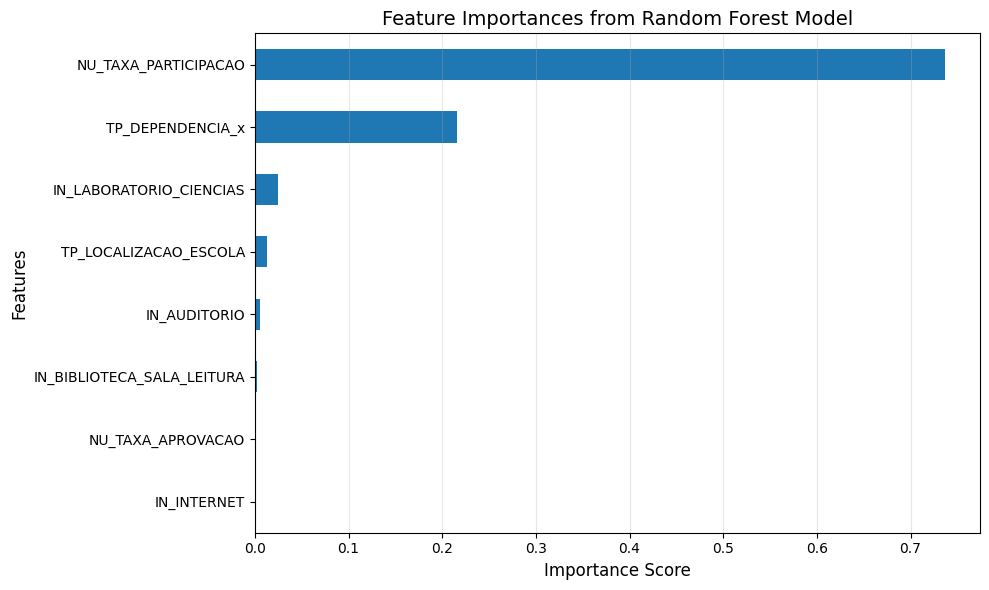

In [48]:
# 1. Access the trained components from the fitted pipeline
preprocessor = model.named_steps['preprocessor']
rf_model = model.named_steps['regressor']

# 2. Get feature names - no need to refit the preprocessor!
# For ColumnTransformer with TargetEncoder and StandardScaler:
feature_names = (
    num_cols +  # Numeric features (StandardScaler preserves names)
    cat_cols +  # Categorical features (TargetEncoder preserves names)
    bin_cols    # Binary features (passed through)
)

# 3. Get importances from the RandomForest model
importances = rf_model.feature_importances_

# 4. Create and plot the importance series
importance_series = pd.Series(importances, index=feature_names).sort_values()

plt.figure(figsize=(10, 6))
importance_series.plot(kind='barh')
plt.title('Feature Importances from Random Forest Model', fontsize=14)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [49]:
importances

array([0.73733869, 0.0008769 , 0.21579844, 0.01311874, 0.00233245,
       0.02503452, 0.00550026, 0.        ])

<Axes: xlabel='NOTA_GERAL_ESCOLA', ylabel='TP_DEPENDENCIA_x'>

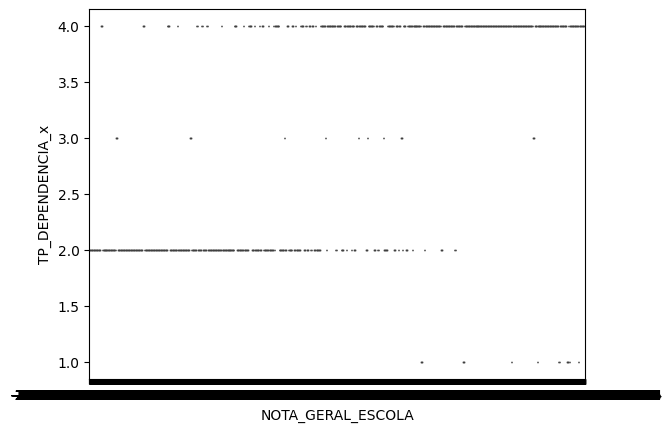

In [53]:

import seaborn as sns
sns.boxplot(x='NOTA_GERAL_ESCOLA', y='TP_DEPENDENCIA_x', data=df)  # Substitua 'target' pelo nome da sua variável alvo